In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [4]:
irs=pd.read_excel('IRS_ALL.xlsx',index_col=0)
irs.index=pd.DatetimeIndex(irs.index)
irs

,收盘价
日期,
2010-04-19,2.1900
2010-04-20,2.1600
2010-04-21,2.1500
2010-04-22,2.1300
2010-04-23,2.1300
...,...
2020-09-24,2.4275
2020-09-25,2.4625
2020-09-28,2.4400


In [9]:
# df_report['发布时间']

In [50]:
# 如果有具体小时分钟数据，才需要用到这里


def adjusted_time(rrr_time):
    """
    输入带有小时、分钟的数据，返回经过调整后的数据
    """
    new_rrr_time=[]
    one_day=datetime.timedelta(days=1)
    for one in rrr_time:
        t=(one[-8:])
        one_time=(datetime.datetime.strptime(one,'%Y-%m-%d %H:%M:%S'))
#         print(t)
        if t>'12:00:00': # 如果时间为超过下午四点半，则记为下一交易日（没有加一天，是因为后面的irs处理会按照下一交易日处理）
            # 这里不太对劲，根据发布时间，改为中午12点
            new_rrr_time+=[one[:10]]
    #         print(t+'==')
        else: # 当前交易日
            new_rrr_time+=[str(one_time-one_day)[:10]]
    #         print(t)
    new_rrr_time=list(set(new_rrr_time)) # 去掉重复时间
    new_rrr_time.sort()

    return new_rrr_time

df_report=pd.read_excel('央行货币政策执行报告.xlsx')
report_time=adjusted_time(df_report['发布时间'])

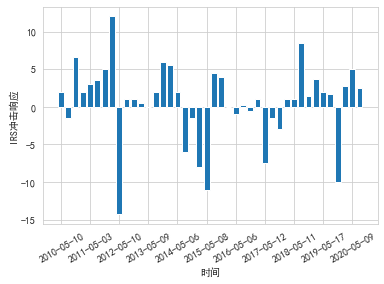

0.05115982245099363

In [57]:

def irs_change(new_rrr_time):
    """
    输入时间数据，返回IRS冲击响应
    """
    change=pd.DataFrame(index=pd.Series(new_rrr_time)[pd.Series(new_rrr_time)>'2010-04-19'],columns=['t1','t0','irs1','irs0'])
#     print(change)
    for one in change.index:
        # 如果当天存在（为交易日）则当天收盘价为初始irs
        if one in irs.index.tolist():
            t0=one
            irs0=irs['收盘价'][one]
        # 否则前一天为初始irs
        else:
            t0=irs[irs.index<one].index.max()
            irs0=irs['收盘价'][t0]
        # 冲击后irs为后一天irs
        t1=(irs[irs.index>one].index.min())
        irs1=irs['收盘价'][t1]

        
        t0,t1=str(t0)[:10],str(t1)[:10]
#         print(one,t1,t0,irs1,irs0)
        
        change.loc[one]=[t1,t0,irs1,irs0]
#         change.loc[one]=[1,2,3,4]

    change['irs_change']=change['irs1']-change['irs0']
    import re
    # x=df['公布时间'].apply(lambda x:re.sub('[^\x00-\xff]','-',x)[:-1])
#     x=new_rrr_time
    # plt.figure(figsize=(10,7))
    plt.bar(change.index,change['irs_change']*100)
    plt.xticks(rotation=30)
    
    
    # 下面部分为设置坐标轴刻度显示密度
    from matplotlib.pyplot import MultipleLocator
    x_major_locator=MultipleLocator(4)
    #把x轴的刻度间隔设置为1，并存在变量里
#     y_major_locator=MultipleLocator(10)
    ax=plt.gca()
    #ax为两条坐标轴的实例
    ax.xaxis.set_major_locator(x_major_locator)
    #把x轴的主刻度设置为1的倍数
#     ax.yaxis.set_major_locator(y_major_locator)
    #把y轴的主刻度设置为10的倍数
    
    
    plt.xlabel('时间')
    plt.ylabel('IRS冲击响应')

    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.show()
    return change

irs_change(report_time)['irs_change'].std()

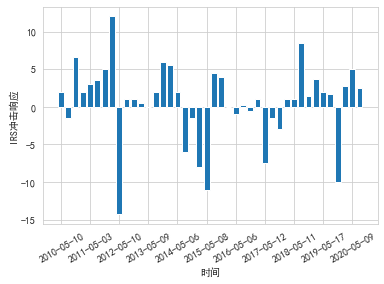

'0.037457 0.000000 0.142500'

In [80]:
def mean_min_max(irs_change):
    abss=np.abs(irs_change)
    return '{:6f} {:6f} {:6f}'.format(abss.mean(),abss.min(),abss.max())
    
    
mean_min_max(irs_change(report_time)['irs_change'])

In [83]:
mean_min_max(np.array((irs-irs.shift(1)).dropna()))

'0.037618 0.000000 1.340000'